## Projeto Módulo do Módulo Banco de dados - Análise das tabelas: Produtos e Vendas.



In [ ]:
import pandas as pd
import numpy as np
from sqlalchemy import MetaData, create_engine
from sqlalchemy.exc import OperationalError
import matplotlib.pyplot as plt
import random

In [4]:
from sqlalchemy import create_engine, MetaData
from sqlalchemy.exc import OperationalError
import pandas as pd

db_url = 'postgresql://postgres:A@localhost:5432/ecommerce'

# Criar uma engine de conexão.
engine = create_engine(db_url)

# Testar a conexão com o banco de dados
try:
    connection = engine.connect()
    print("Conexão bem-sucedida! \n")
except OperationalError as e:
    print("Erro ao conectar ao banco de dados, verifique os parâmetros.", e)

# Verificar se as tabelas já existem no banco de dados
meta = MetaData()
meta.reflect(bind=engine)

if 'produtos' in meta.tables and 'vendas' in meta.tables:
    print("As tabelas 'produtos' e 'vendas' já existem. Banco de dados pronto para uso.")
else:
    # Ler e inserir dados das planilhas 'produtos' e 'vendas' CSV no banco de dados.
    for file_name in ["produtos.csv", "vendas.csv"]:
        df = pd.read_csv(file_name, sep=',')
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')].copy()
        # Salva o dataframe como tabela no banco conectado
        df.to_sql(f'{file_name.split(".")[0]}', engine, index=False)
        print(f"A tabela '{file_name.split('.')[0]}' foi adicionada. Banco de dados pronto para uso.")

# Fechar a conexão com o banco de dados
connection.close()
print("Conexão fechada.")


Conexão bem-sucedida! 

As tabelas 'produtos' e 'vendas' já existem. Banco de dados pronto para uso.
Conexão fechada.


O formato para cada pergunta é:
- Criação da View SQL.
- Exibição em gráfico.
- Curto comentário.


### Pergunta 1: Qual produto e a quantidade mais vendida em cada País?

```sql
CREATE OR REPLACE VIEW ranking_products_of_country AS
WITH ranked_sales AS (
    SELECT 
        "ship-country" AS pais,
        SUM("Qty") AS quantidade_total,
        p."Produto" AS codigo_produtos,
        ROW_NUMBER() OVER (PARTITION BY "ship-country" ORDER BY SUM("Qty") DESC) AS rank
    FROM 
        vendas v
    INNER JOIN 
        produtos p ON v."Codigo" = p."Codigo"
    GROUP BY 
        "ship-country", p."Produto"
)
SELECT 
    pais,
    quantidade_total,
    codigo_produtos
FROM 
    ranked_sales
WHERE 
    rank = 1;
```

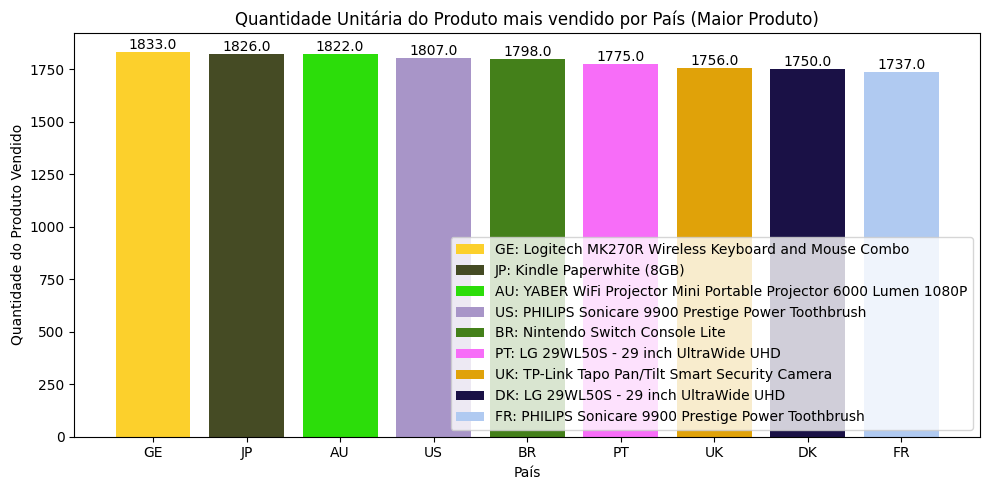

In [29]:
# Consulta SQL para visualizar a view.
query_view = "SELECT * FROM ranking_products_of_country"

# Ler os dados da view e criar o DataFrame
df_view = pd.read_sql(query_view, engine)

# Ordenar os dados com base na quantidade total em ordem decrescente
sorted_data = sorted(zip(df_view['pais'], df_view['quantidade_total'], df_view['codigo_produtos']), key=lambda x: x[1], reverse=True)

# Descompactar os dados ordenados
paises, quantidades, codigos_produtos = zip(*sorted_data)

# Criar o gráfico de barras
plt.figure(figsize=(10, 5))
bars = []
for pais, quantidade, codigo_produto in zip(paises, quantidades, codigos_produtos):
    cor = "#{:06x}".format(random.randint(0, 0xFFFFFF))  # Gera uma cor aleatoaria
    bar = plt.bar(pais, quantidade, color=cor, label=f'{pais}: {codigo_produto}')
    bars.append(bar)

# Adicionar os valores no topo das barras
for bar in bars:
    for b in bar:
        yval = b.get_height()
        plt.text(b.get_x() + b.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.xlabel('País')
plt.ylabel('Quantidade do Produto Vendido')
plt.title('Quantidade Unitária do Produto mais vendido por País (Maior Produto)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()



### Pergunta 2: Qual o volume de total de vendas por País?

```sql
CREATE OR REPLACE VIEW ranking_country_sells AS
SELECT 
    "ship-country" AS pais,
    SUM("Qty") AS quantidade_total
FROM 
    vendas
GROUP BY 
    "ship-country";
```

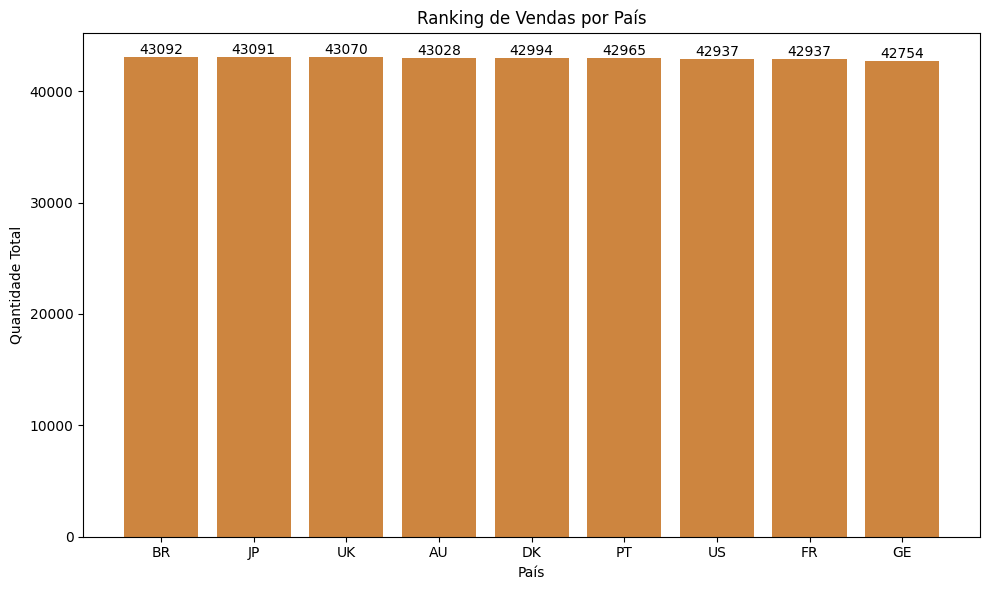

In [44]:
# Consulta SQL para visualizar a view.
query_view = "SELECT * FROM ranking_country_sells;"
df_view = pd.read_sql(query_view, engine)

# Ordenar os dados com base na quantidade total em ordem decrescente
df_view_sorted = df_view.sort_values(by='quantidade_total', ascending=False)

# Plotar o gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(df_view_sorted['pais'], df_view_sorted['quantidade_total'], color='peru')

# Adicionar o valor do total no topo de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), ha='center', va='bottom')

plt.xlabel('País')
plt.ylabel('Quantidade Total')
plt.title('Ranking de Vendas por País')
plt.tight_layout()  



### Pergunta 3: Qual o faturamento mensal do período no Brasil (BR)?

```sql
CREATE OR REPLACE VIEW fat_mbr AS
SELECT 
    TO_CHAR(TO_DATE(v."Date", 'MM/DD/YYYY'), 'MM-YYYY') AS mes,
    ROUND(SUM(CAST(REPLACE(p."Preco", '$', '') AS FLOAT))::numeric, 2) as faturamento_total
FROM 
    vendas v
INNER JOIN 
    produtos p ON v."Codigo" = p."Codigo"
WHERE 
    v."Courier Status" = 'Shipped' AND v."ship-country" = 'BR'
GROUP BY 
    TO_CHAR(TO_DATE(v."Date", 'MM/DD/YYYY'), 'MM-YYYY');

```

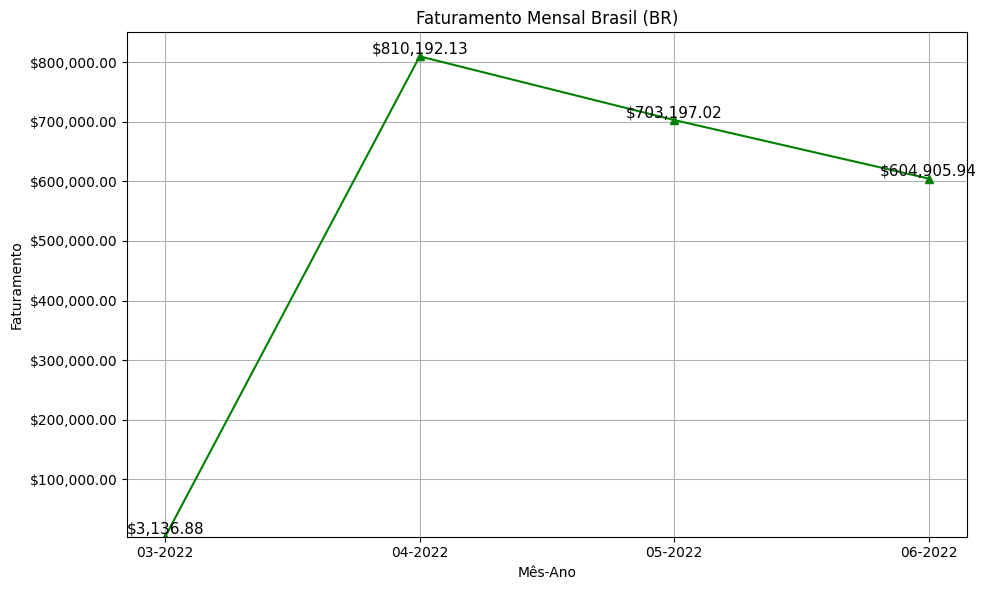

In [9]:
# Consulta SQL para visualizar a view.
query_view = "SELECT * FROM fat_mbr;"
df_view = pd.read_sql(query_view, engine)
engine.dispose()

meses = df_view['mes']
faturamento_total = df_view['faturamento_total']

# Criar o gráfico de linha
plt.figure(figsize=(10, 6))
plt.plot(meses, faturamento_total, marker='^', color='green', linestyle='-')
plt.xlabel('Mês-Ano')
plt.ylabel('Faturamento')
plt.title('Faturamento Mensal Brasil (BR)')
plt.grid(True)

# Ajustar o limite inferior do eixo y para o primeiro valor do faturamento total
plt.ylim(ymin=faturamento_total.iloc[0])

# Adicionar os valores de cada ponto
for i, txt in enumerate(faturamento_total):
    plt.text(meses[i], faturamento_total[i], f'${txt:,.2f}', ha='center', va='bottom', fontsize= 11)
# Formatando manualmente o eixo y como moeda
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.2f}'))

plt.tight_layout()
plt.show()

### Pergunta 4: Qual produto teve mais pedidos cancelados e seu Prejuízo Acumulado?

```SQL
CREATE VIEW cancelamentos_prejuizo AS
SELECT
    p."Produto" AS Codigo_produtos,
    COUNT(*) AS total_cancelamentos,
    SUM(v."Qty" * CAST(REPLACE(p."Preco", '$', '') AS FLOAT)) AS prejuizo_total
FROM vendas v
INNER JOIN produtos p ON v."Codigo" = p."Codigo"
WHERE v."Courier Status" = 'Cancelled'
GROUP BY p."Produto"
ORDER BY total_cancelamentos DESC;

```

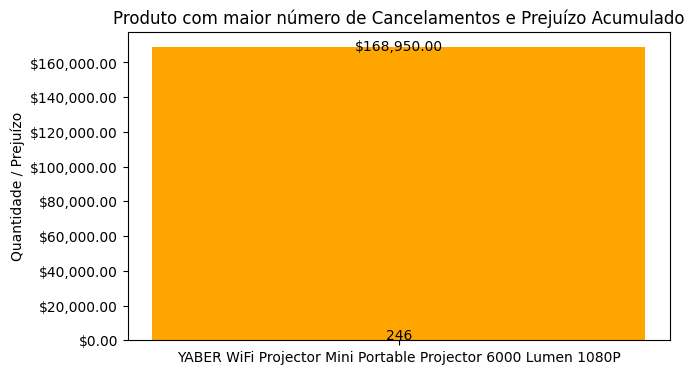

In [146]:
query_view = "SELECT * FROM cancelamentos_prejuizo limit 1;"

df_view = pd.read_sql(query_view, engine)
codigo_produtos = df_view['codigo_produtos']
total_cancelamentos = df_view['total_cancelamentos']
prejuizo_total = df_view['prejuizo_total']

# Criar o gráfico de barras
plt.figure(figsize=(7, 4))

# Plotar os dados para cada produto
for i in range(len(codigo_produtos)):
    plt.bar(codigo_produtos[i], prejuizo_total[i], color='orange', label='Prejuízo Total')
    # Adicionar texto com o valor acima de cada barra
    plt.text(codigo_produtos[i], total_cancelamentos[i] + 5, str(total_cancelamentos[i]), ha='center')
    plt.text(codigo_produtos[i], prejuizo_total[i] + 500, f'${prejuizo_total[i]:,.2f}', ha='center', va='center')

plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.2f}'))
# Adicionar legendas e rótulos
plt.ylabel('Quantidade / Prejuízo')
plt.title('Produto com maior número de Cancelamentos e Prejuízo Acumulado')
plt.show()



### Pergunta 5: Qual foi o dia com maior número de pedidos em cada país?

```sql
CREATE VIEW rank_dia_pais AS
SELECT DISTINCT ON ("ship-country")
    "ship-country",
    "Date",
    COUNT("Order ID") AS total_orders
FROM
    vendas
GROUP BY
    "ship-country",
    "Date"
ORDER BY
    "ship-country",
    COUNT("Order ID") DESC;
```

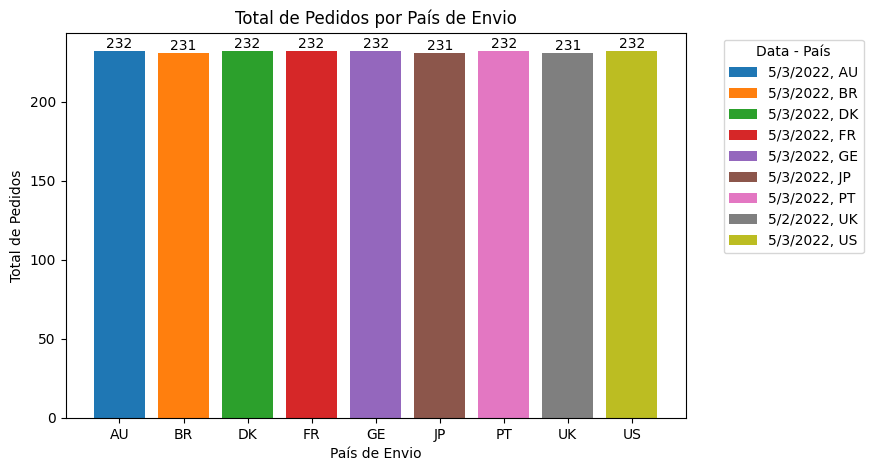

In [11]:
# Consulta SQL para visualizar a view.
query_view = "SELECT * FROM rank_dia_pais;"
df_view = pd.read_sql(query_view, engine)

# Criar o gráfico de barras
colors = plt.cm.tab10(np.arange(len(df_view['Date'])))

# Criar o gráfico de barras
plt.figure(figsize=(8, 5))

# Plotar os dados
bars = plt.bar(df_view['ship-country'], df_view['total_orders'], color=colors)

# Adicionar título e rótulos aos eixos
plt.xlabel('País de Envio')
plt.ylabel('Total de Pedidos')
plt.title('Total de Pedidos por País de Envio')

# Adicionar a data como legenda para cada barra
for bar, date, country, total_orders in zip(bars, df_view['Date'], df_view['ship-country'], df_view['total_orders']):
    bar.set_label(f"{date}, {country}")
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), total_orders, ha='center', va='bottom')

# Exibir as legendas
plt.legend(title='Data - País', bbox_to_anchor=(1.05, 1), loc='upper left')

# Exibir o gráfico
plt.show()

### Pergunta 6: Qual a dispersão dos valores dos produtos?

```sql
CREATE VIEW dvp_preco AS
SELECT 
    "Produto",
    CAST(REPLACE("Preco", '$', '') AS FLOAT) AS "Preco"
FROM 
    produtos;
```

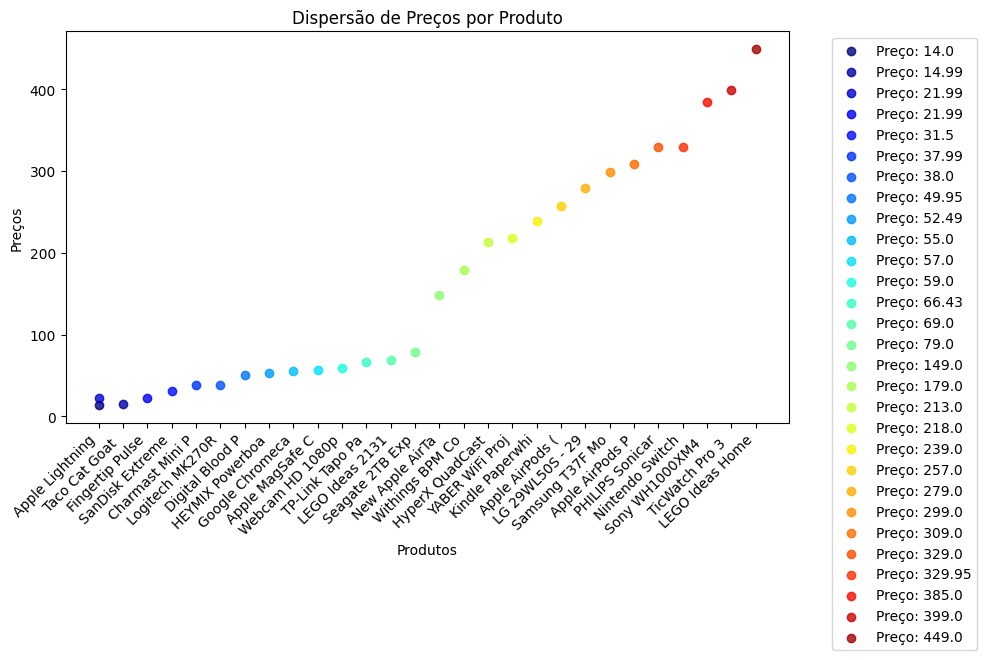

In [8]:
query_view = "SELECT * FROM dvp_preco;"
df_view = pd.read_sql(query_view, engine)
engine.dispose()

df_view_sorted = df_view.sort_values(by='Preco')

produtos = [produto[:15] for produto in df_view_sorted['Produto']]
precos = df_view_sorted['Preco']

cores = np.arange(len(precos))

# Plotando o gráfico de dispersão
plt.figure(figsize=(10, 6))  # Definindo o tamanho da figura

# Plotando o gráfico de dispersão
for produto, preco, cor in zip(produtos, precos, cores):
    plt.scatter(produto, preco, color=plt.cm.jet(cor / len(precos)), alpha=0.8, label=f'Preço: {preco}')

# Adicionando rótulos e título
plt.xlabel('Produtos')
plt.ylabel('Preços')
plt.title('Dispersão de Preços por Produto')

# Rotacionando os rótulos do eixo x para melhor visualização
plt.xticks(rotation=45, ha='right')

# Adicionando legenda
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Exibindo o gráfico
plt.tight_layout()
plt.show()

### Pergunta 7: Qual produto teve mais status de Cancelamento por país?

```sql
CREATE VIEW cancel_country AS
WITH CancelamentosPorPais AS (
    SELECT 
        "ship-country" AS Pais,
        p."Produto" AS Codigo_produtos,
        COUNT(*) AS Total_Cancelled,
        ROW_NUMBER() OVER (PARTITION BY "ship-country" ORDER BY COUNT(*) DESC) AS Rank
    FROM vendas v
    INNER JOIN produtos p ON v."Codigo" = p."Codigo"
    WHERE "Courier Status" = 'Cancelled'
    GROUP BY "ship-country", p."Produto"
)
SELECT Pais, Codigo_produtos, Total_Cancelled
FROM CancelamentosPorPais
WHERE Rank = 1;
```

In [16]:
#Consulta Simples
query_view = "SELECT * FROM cancel_country;"
df_view = pd.read_sql(query_view, engine)
print(df_view)

  pais                                    codigo_produtos  total_cancelled
0   AU                            Kindle Paperwhite (8GB)               32
1   BR  YABER WiFi Projector Mini Portable Projector 6...               43
2   DK                       Nintendo Switch Console Lite               32
3   FR                 LG 29WL50S - 29 inch UltraWide UHD               35
4   GE        TP-Link Tapo Pan/Tilt Smart Security Camera               34
5   JP                 LG 29WL50S - 29 inch UltraWide UHD               34
6   PT  HyperX QuadCast S – RGB USB Condenser Micropho...               38
7   UK                   Google Chromecast 3rd Generation               33
8   US        TP-Link Tapo Pan/Tilt Smart Security Camera               35


### Pergunta 8: Qual produto teve mais status de Shipped por país?

```sql
CREATE VIEW shipped_country AS
WITH ShippedporPais AS (
    SELECT 
        "ship-country" AS Pais,
        p."Produto" AS Codigo_produtos,
        COUNT(*) AS Total_shipped,
        ROW_NUMBER() OVER (PARTITION BY "ship-country" ORDER BY COUNT(*) DESC) AS Rank
    FROM vendas v
    INNER JOIN produtos p ON v."Codigo" = p."Codigo"
    WHERE "Courier Status" = 'Shipped'
    GROUP BY "ship-country", p."Produto"
)
SELECT Pais, Codigo_produtos, Total_shipped
FROM ShippedporPais
WHERE Rank = 1;
```

In [18]:
#Consulta Simples
query_view = "SELECT * FROM shipped_country;"
df_view = pd.read_sql(query_view, engine)
print(df_view)

  pais                                    codigo_produtos  total_shipped
0   AU  YABER WiFi Projector Mini Portable Projector 6...            536
1   BR                 LG 29WL50S - 29 inch UltraWide UHD            529
2   DK        TP-Link Tapo Pan/Tilt Smart Security Camera            530
3   FR    PHILIPS Sonicare 9900 Prestige Power Toothbrush            531
4   GE  Logitech MK270R Wireless Keyboard and Mouse Combo            536
5   JP                            Kindle Paperwhite (8GB)            527
6   PT        TP-Link Tapo Pan/Tilt Smart Security Camera            524
7   UK        TP-Link Tapo Pan/Tilt Smart Security Camera            524
8   US  YABER WiFi Projector Mini Portable Projector 6...            543


### Pergunta 9: Qual Order ID foi o de maior venda por País?

```sql
CREATE VIEW Maior_Venda_Por_Pais AS
WITH Vendas_Com_Rank AS (
    SELECT
        v."Order ID",
        v."ship-country",
        SUM(v."Qty" * CAST(REPLACE(p."Preco", '$', '') AS FLOAT)) AS v_venda,
        ROW_NUMBER() OVER(PARTITION BY v."ship-country" ORDER BY SUM(v."Qty" * CAST(REPLACE(p."Preco", '$', '') AS FLOAT)) DESC) AS rank_venda
    FROM vendas v
    INNER JOIN produtos p ON v."Codigo" = p."Codigo"
    WHERE v."Courier Status" = 'Shipped'
    GROUP BY v."Order ID", v."ship-country"
)
SELECT
    "Order ID",
    "ship-country",
    v_venda
FROM Vendas_Com_Rank
WHERE rank_venda = 1;
```

In [23]:
#Consulta Simples
query_view = "SELECT * FROM Maior_Venda_Por_Pais;"
df_view = pd.read_sql(query_view, engine)
print(df_view)

              Order ID ship-country  v_venda
0  402-1389258-8743547           AU   2245.0
1  405-7370736-4938748           BR   2245.0
2  171-1420495-1972325           DK   2245.0
3  408-2069605-0760343           FR   2245.0
4  408-4118660-2696340           GE   2245.0
5  408-9609778-9623556           JP   2245.0
6  406-2608680-0539554           PT   2245.0
7  171-1129821-8231536           UK   2245.0
8  408-3350646-9694714           US   2245.0


### Pergunta 10: Qual Order ID foi o de menor venda por País?

```sql
CREATE VIEW Maior_Venda_Por_Pais AS
WITH Vendas_Com_Rank AS (
    SELECT
        v."Order ID",
        v."ship-country",
        SUM(v."Qty" * CAST(REPLACE(p."Preco", '$', '') AS FLOAT)) AS v_venda,
        ROW_NUMBER() OVER(PARTITION BY v."ship-country" ORDER BY SUM(v."Qty" * CAST(REPLACE(p."Preco", '$', '') AS FLOAT)) ASC) AS rank_venda
    FROM vendas v
    INNER JOIN produtos p ON v."Codigo" = p."Codigo"
    WHERE v."Courier Status" = 'Shipped'
    GROUP BY v."Order ID", v."ship-country"
)
SELECT
    "Order ID",
    "ship-country",
    v_venda
FROM Vendas_Com_Rank
WHERE rank_venda = 1;
```

In [25]:
#Consulta Simples
query_view = "SELECT * FROM Menor_Venda_Por_Pais;"
df_view = pd.read_sql(query_view, engine)
print(df_view)

              Order ID ship-country  v_venda
0  403-4232109-2561938           AU     14.0
1  408-8525813-1796368           BR     14.0
2  402-2204493-3593166           DK     14.0
3  402-9226250-2259547           FR     14.0
4  408-5943511-0799528           GE     14.0
5  408-4353419-8945938           JP     14.0
6  405-0160552-6998761           PT     14.0
7  406-6766556-5966702           UK     14.0
8  408-7321687-2802764           US     14.0


### Pergunta 11: Qual a quantidade de pedidos por data?

```sql
CREATE VIEW PedidosPorData AS
SELECT 
    TO_CHAR(TO_DATE(v."Date", 'MM/DD/YYYY'), 'DD-MM-YYYY') AS Data,
    COUNT(*) AS total_pedidos,
    RANK() OVER (ORDER BY COUNT(*) DESC) AS ranking
FROM vendas v
GROUP BY "Date"
ORDER BY total_pedidos DESC, ranking;

```

In [27]:
#Consulta Simples
query_view = "SELECT * FROM PedidosPorData;"
df_view = pd.read_sql(query_view, engine)
print(df_view)

          data  total_pedidos  ranking
0   03-05-2022           2085        1
1   02-05-2022           2079        2
2   04-05-2022           2015        3
3   14-04-2022           1883        4
4   15-04-2022           1853        5
..         ...            ...      ...
86  23-06-2022           1090       87
87  24-06-2022           1028       88
88  25-06-2022           1026       89
89  29-06-2022            658       90
90  31-03-2022            171       91

[91 rows x 3 columns]


### Pergunta 12: Como se divide a quantidade de pedidos pelo Ship Service Level?

```sql
CREATE VIEW div_ship_service AS
SELECT "ship-service-level", COUNT(*) AS total_pedidos
FROM vendas
GROUP BY "ship-service-level";
```

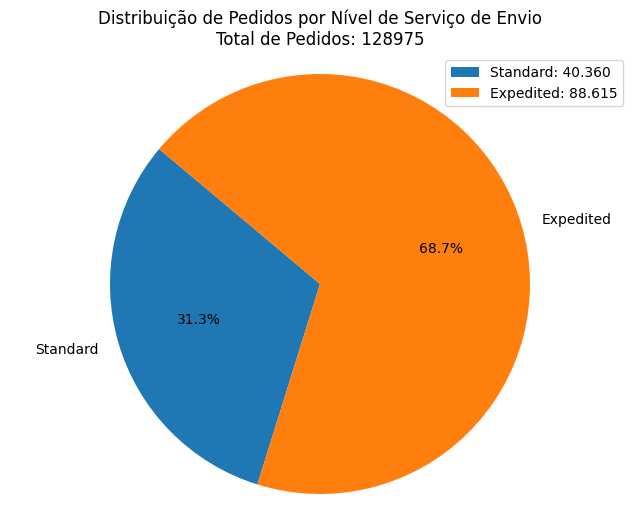

In [50]:
#Consulta Simples
query_view = "SELECT * FROM div_ship_service;"
df_view = pd.read_sql(query_view, engine) 

# Calcular o valor total de pedidos
total_pedidos_total = df_view['total_pedidos'].sum()

# Criar gráfico de pizza
plt.figure(figsize=(8, 6))
patches, texts, _ = plt.pie(df_view['total_pedidos'], labels=df_view['ship-service-level'], autopct='%1.1f%%', startangle=140)

# Adicionar legenda colorida com o valor total
legend_labels = [f'{label}: {value/1000:.3f}' for label, value in zip(df_view['ship-service-level'], df_view['total_pedidos'])]
plt.legend(patches, legend_labels, loc="best")

# Adicionar título com o valor total
plt.title(f'Distribuição de Pedidos por Nível de Serviço de Envio\nTotal de Pedidos: {total_pedidos_total}')

# Mostrar o gráfico
plt.axis('equal')  # Assegurar que o gráfico seja circular
plt.show()

### Pergunta 13: Qual a média da quantidade (Qty) por país?

```sql
CREATE VIEW media_quantidade_por_pais AS
SELECT "ship-country", AVG("Qty") AS media_quantidade
FROM vendas
GROUP BY "ship-country";
```

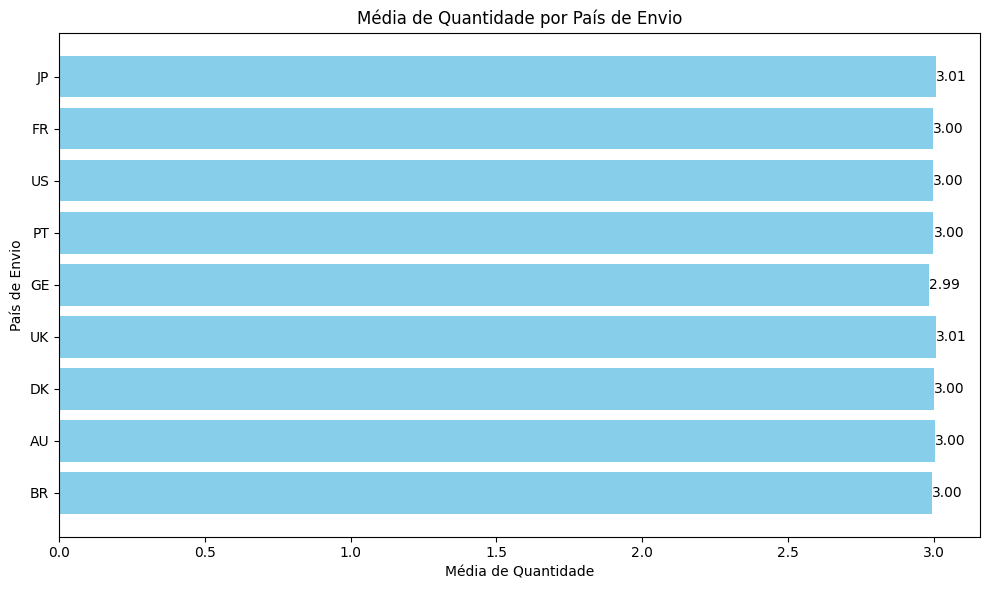

In [9]:
query_view = "SELECT * FROM media_quantidade_por_pais;"
df_view = pd.read_sql(query_view, engine) 

# Plotar o gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.barh(df_view['ship-country'], df_view['media_quantidade'], color='skyblue')

# Adicionar os valores da média dentro de cada barra
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.2f}', 
             va='center', ha='left')

# Adicionar rótulos e título
plt.xlabel('Média de Quantidade')
plt.ylabel('País de Envio')
plt.title('Média de Quantidade por País de Envio')

# Exibir o gráfico
plt.tight_layout()
plt.show()

### Pergunta 14: Qual a mediana de cada produto (Qty) por país?

```sql
CREATE OR REPLACE VIEW mediana_por_produto AS
WITH QuantidadesPorProduto AS (
    SELECT
        p."Produto" AS Codigo_produtos,
        v."Qty",
        NTILE(2) OVER(PARTITION BY p."Produto" ORDER BY v."Qty") AS Quantile
    FROM vendas v
    INNER JOIN produtos p ON v."Codigo" = p."Codigo"
)
SELECT
    Codigo_produtos,
    AVG("Qty") AS Mediana
FROM QuantidadesPorProduto
WHERE Quantile = 2
GROUP BY Codigo_produtos;
```

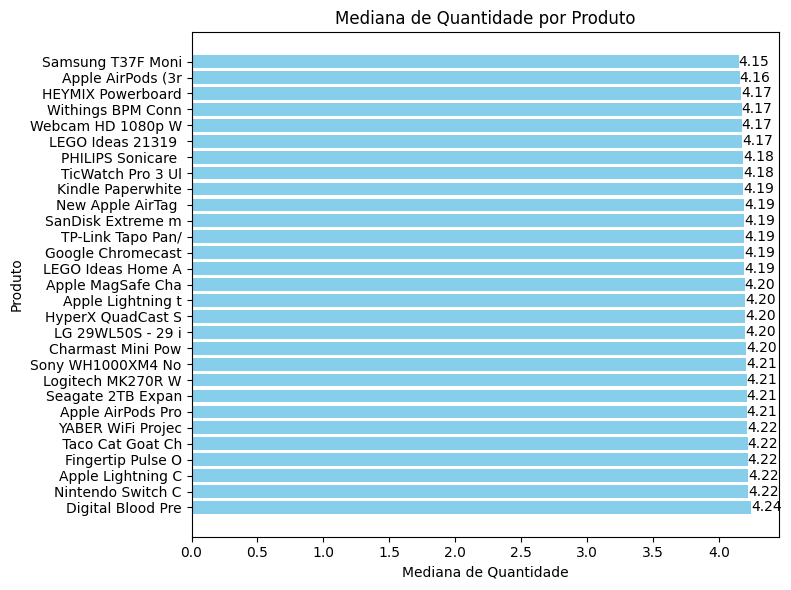

In [29]:
query_view = "SELECT * FROM mediana_por_produto;"
df_view = pd.read_sql(query_view, engine)
#print(df_view)

produtos = [produto[:17] for produto in df_view_sorted['codigo_produtos']]
mediana = df_view_sorted['mediana']

# Plotar o gráfico de barras horizontais
plt.figure(figsize=(8, 6))
bars = plt.barh(produtos, mediana, color='skyblue')

# Adicionar os valores da mediana dentro de cada barra
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.2f}', 
             va='center', ha='left')

# Adicionar rótulos e título
plt.xlabel('Mediana de Quantidade')
plt.ylabel('Produto')
plt.title('Mediana de Quantidade por Produto')

# Exibir o gráfico
plt.tight_layout()
plt.show()



### Pergunta 15: Como saber qual produto foi mais ventido para cada país?

```sql
CREATE OR REPLACE VIEW ranking_totalproducts_of_country AS
WITH ranked_sales AS (
    SELECT 
        "ship-country" AS pais,
        SUM("Qty") AS quantidade_total,
        p."Produto" AS codigo_produtos,
        ROW_NUMBER() OVER (PARTITION BY p."Produto" ORDER BY SUM("Qty") DESC) AS rank
    FROM 
        vendas v
    INNER JOIN 
        produtos p ON v."Codigo" = p."Codigo"
    GROUP BY 
        "ship-country", p."Produto"
)
SELECT 
    pais,
    quantidade_total,
    codigo_produtos
FROM 
    ranked_sales
WHERE 
    rank = 1;
```

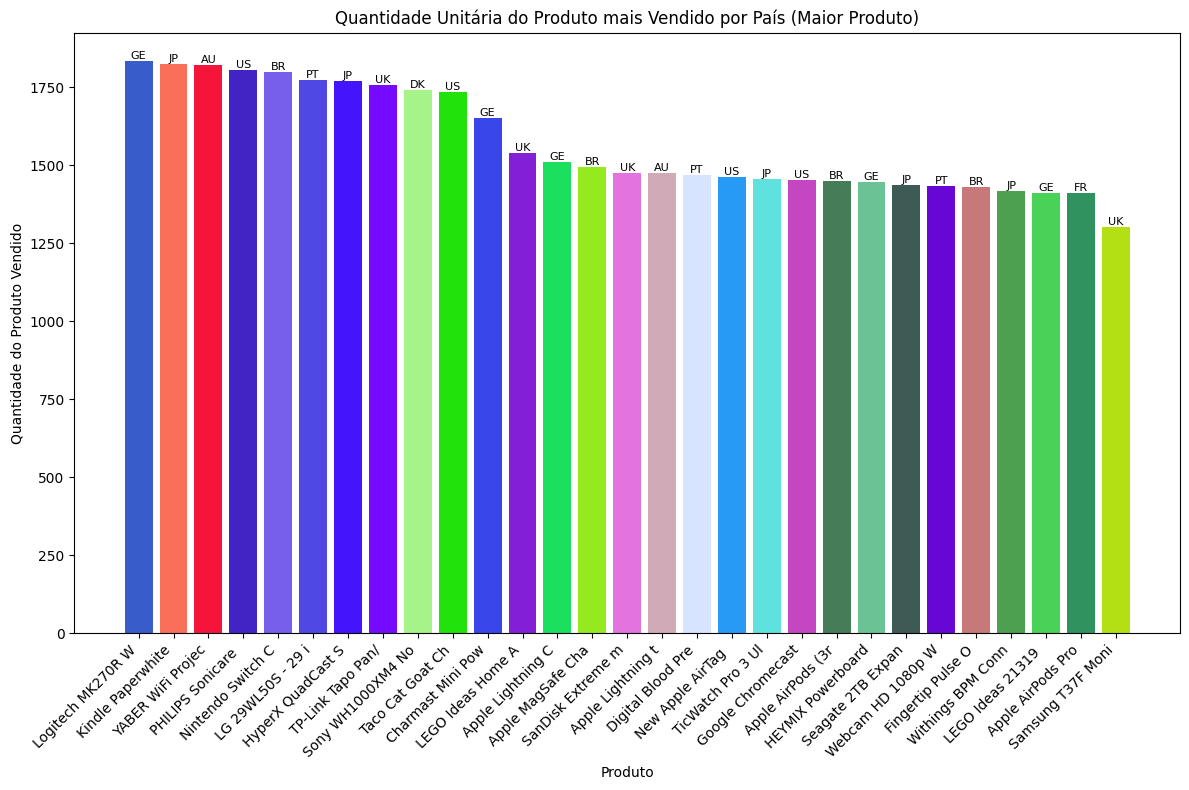

In [47]:
query_view = "SELECT * FROM ranking_totalproducts_of_country;"
# Ler os dados da view e criar o DataFrame
df_view_sorted = df_view.sort_values(by='quantidade_total', ascending=False)


# Ajustar o tamanho do nome do produto para exibição no eixo x
codigo_produto = [produto[:17] for produto in df_view_sorted['codigo_produtos']]

# Criar o gráfico de barras
plt.figure(figsize=(12, 8))
bars = []
for i, pais in enumerate(df_view_sorted['pais']):
    cor = "#{:06x}".format(random.randint(0, 0xFFFFFF))  # Gera uma cor aleatória
    bar = plt.bar(codigo_produto[i], df_view_sorted.iloc[i]['quantidade_total'], color=cor)
    bars.append(bar)
    
    # Adicionar o nome do país no topo da barra
    plt.text(bar[0].get_x() + bar[0].get_width() / 2, bar[0].get_height(), pais,
             ha='center', va='bottom', fontsize=8, color='black')

plt.xlabel('Produto')
plt.ylabel('Quantidade do Produto Vendido')
plt.title('Quantidade Unitária do Produto mais Vendido por País (Maior Produto)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()